In [1]:
# ====================================================================
# WEEK 5: STATISTICAL ANALYSIS
# DNA Gene Mapping Project
# Author: Sharique Mohammad
# Date: 11 January 2026
# ====================================================================
# jupyter_notebooks/01_statistical_analysis.ipynb
# ====================================================================

In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
from pathlib import Path
import warnings

In [3]:
# Suppress warnings for cleaner output

warnings.filterwarnings("ignore")
load_dotenv()

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


In [4]:
# Setup Paths

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'jupyter_notebooks' else Path.cwd()
ANALYTICAL_DIR = PROJECT_ROOT / "data" / "analytical"
VIZ_DIR = ANALYTICAL_DIR / "visualizations"

# Create directories if they don't exist
ANALYTICAL_DIR.mkdir(parents=True, exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Analytical directory: {ANALYTICAL_DIR}")
print(f"Visualizations directory: {VIZ_DIR}")

Project root: C:\Users\Sharique\Desktop\Self_Project\GitHub_Project\genomic-variant-data-science-pipeline
Analytical directory: C:\Users\Sharique\Desktop\Self_Project\GitHub_Project\genomic-variant-data-science-pipeline\data\analytical
Visualizations directory: C:\Users\Sharique\Desktop\Self_Project\GitHub_Project\genomic-variant-data-science-pipeline\data\analytical\visualizations


In [5]:
# Database Connection

DB_CONFIG = {
    'host': os.getenv('POSTGRES_HOST', 'localhost'),
    'port': int(os.getenv('POSTGRES_PORT', 5432)),
    'database': os.getenv('POSTGRES_DATABASE', 'genome_db'),
    'user': os.getenv('POSTGRES_USER', 'postgres'),
    'password': os.getenv('POSTGRES_PASSWORD')
}

engine = create_engine(
    f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}"
    f"@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
)

conn = psycopg2.connect(
    host=DB_CONFIG['host'],
    database=DB_CONFIG['database'],
    user=DB_CONFIG['user'],
    password=DB_CONFIG['password']
)

print("Database connection established")

Database connection established


In [6]:
# Load Data from PostgreSQL

print("Loading data from PostgreSQL gold layer...")

df_gene_features = pd.read_sql("SELECT * FROM gold.gene_features", engine)
df_chromosome_features = pd.read_sql("SELECT * FROM gold.chromosome_features", engine)
df_gene_disease = pd.read_sql("SELECT * FROM gold.gene_disease_association", engine)
df_ml_features = pd.read_sql("SELECT * FROM gold.ml_features", engine)

print(f"Loaded {len(df_gene_features)} genes")
print(f"Loaded {len(df_chromosome_features)} chromosomes")
print(f"Loaded {len(df_gene_disease)} gene-disease associations")
print(f"Loaded {len(df_ml_features)} ML features")

Loading data from PostgreSQL gold layer...
Loaded 171 genes
Loaded 10 chromosomes
Loaded 62 gene-disease associations
Loaded 171 ML features


In [7]:
# Data Cleaning and Preparation

print("\n" + "="*40)
print("DATA CLEANING AND PREPARATION")
print("="*40)

# Remove rows with NULL chromosome (can't analyze by chromosome if NULL)
df_clean = df_gene_features[df_gene_features['chromosome'].notna()].copy()
print(f"Removed {len(df_gene_features) - len(df_clean)} genes with NULL chromosome")
print(f"Working with {len(df_clean)} genes")

# Use total_pathogenic instead of pathogenic_ratio if all zeros
if df_clean['pathogenic_ratio'].sum() == 0:
    print("\nWARNING: All pathogenic_ratio values are 0")
    print("This likely means data uses total_pathogenic instead")
    print("Creating pathogenic_ratio from total_pathogenic/mutation_count")
    df_clean['pathogenic_ratio'] = df_clean['total_pathogenic'] / df_clean['mutation_count']


DATA CLEANING AND PREPARATION
Removed 142 genes with NULL chromosome
Working with 29 genes

This likely means data uses total_pathogenic instead
Creating pathogenic_ratio from total_pathogenic/mutation_count


In [8]:
# Data Overview

print("\n" + "="*40)
print("GENE FEATURES OVERVIEW")
print("="*40)
print(df_clean.head())
print("\nData Shape:", df_clean.shape)
print("\nData Types:")
print(df_clean.dtypes)
print("\nBasic Statistics:")
print(df_clean.describe())


GENE FEATURES OVERVIEW
   gene_name  mutation_count  pathogenic_count  likely_pathogenic_count  \
1       EGFR             495                 0                        0   
2        NF1             484                 0                        0   
3       CDH1             496                 0                        0   
9      BRCA1             493                 0                        0   
10       ATM             489                 0                        0   

    benign_count  likely_benign_count  disease_count  variant_type_count  \
1              0                    0              1                   1   
2              0                    0              1                   1   
3              0                    0              1                   1   
9              0                    0              1                   1   
10             0                    0              1                   1   

    avg_position  total_pathogenic  total_benign  pathogenic_ratio  

In [9]:
# Missing Value Analysis

print("\n" + "="*40)
print("MISSING VALUE ANALYSIS")
print("="*40)

missing_data = pd.DataFrame({
    'Column': df_clean.columns,
    'Missing_Count': df_clean.isnull().sum(),
    'Missing_Percentage': (df_clean.isnull().sum() / len(df_clean) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_data) > 0:
    print("\nColumns with missing values:")
    print(missing_data)
    print("\nNote: Missing values in gene_id, gene_type, gene_length are expected")
    print("      Not all genes have complete metadata")
else:
    print("\nNo missing values found")


MISSING VALUE ANALYSIS

Columns with missing values:
                            Column  Missing_Count  Missing_Percentage
mutation_density  mutation_density             11               37.93

Note: Missing values in gene_id, gene_type, gene_length are expected
      Not all genes have complete metadata



DISTRIBUTION ANALYSIS - MUTATION COUNTS


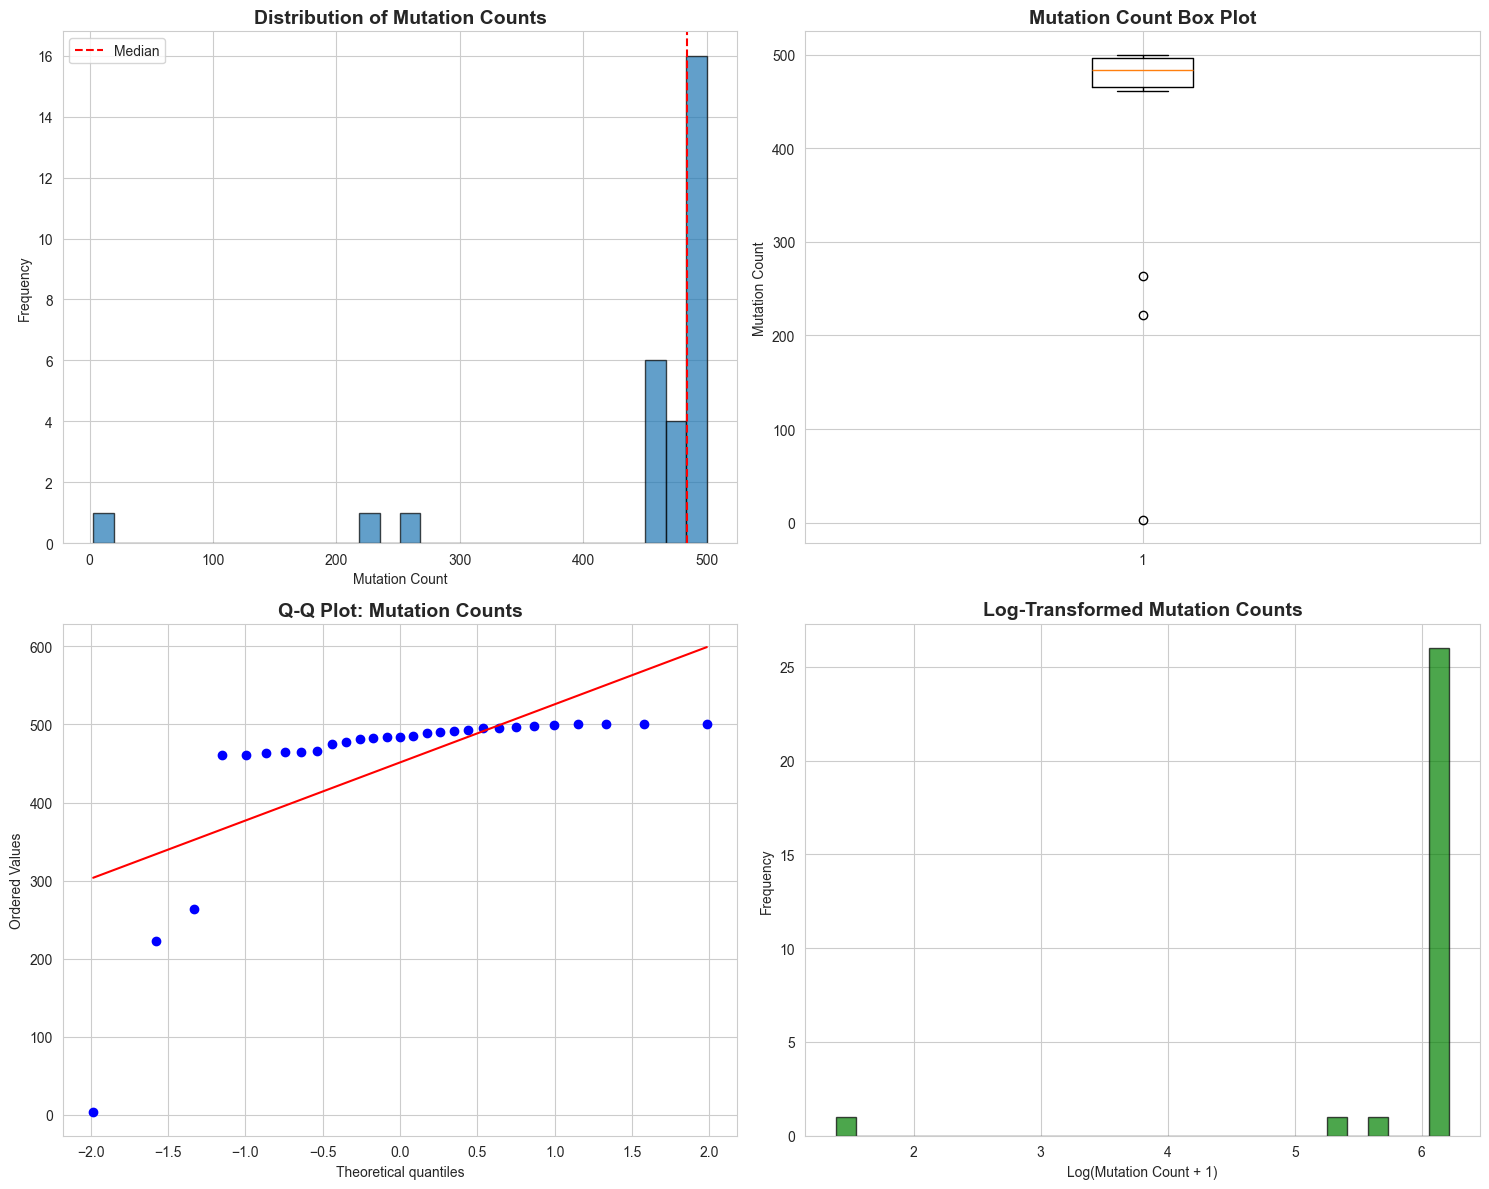


Mutation Count Statistics:
  Mean: 451.38
  Median: 484.00
  Std Dev: 107.28
  Min: 3
  Max: 500

Shapiro-Wilk Test for Normality (sample of 29):
  Statistic: 0.4671
  P-value: 0.0000
  Result: Data is NOT normally distributed
  Note: This is expected for genomic data (typically right-skewed)


In [10]:
# Distribution Analysis - Mutation Counts

print("\n" + "="*40)
print("DISTRIBUTION ANALYSIS - MUTATION COUNTS")
print("="*40)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Histogram
axes[0, 0].hist(df_clean['mutation_count'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Mutation Counts', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Mutation Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_clean['mutation_count'].median(), color='red', 
                   linestyle='--', label='Median')
axes[0, 0].legend()

# Box plot
axes[0, 1].boxplot(df_clean['mutation_count'], vert=True)
axes[0, 1].set_title('Mutation Count Box Plot', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Mutation Count')

# Q-Q plot
stats.probplot(df_clean['mutation_count'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Mutation Counts', fontsize=14, fontweight='bold')

# Log-transformed histogram
log_mutations = np.log1p(df_clean['mutation_count'])
axes[1, 1].hist(log_mutations, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].set_title('Log-Transformed Mutation Counts', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Log(Mutation Count + 1)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig(VIZ_DIR / 'mutation_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMutation Count Statistics:")
print(f"  Mean: {df_clean['mutation_count'].mean():.2f}")
print(f"  Median: {df_clean['mutation_count'].median():.2f}")
print(f"  Std Dev: {df_clean['mutation_count'].std():.2f}")
print(f"  Min: {df_clean['mutation_count'].min()}")
print(f"  Max: {df_clean['mutation_count'].max()}")

# Normality test (use sample of 50 if more than 50 genes)
sample_size = min(50, len(df_clean))
stat, p_value = stats.shapiro(df_clean['mutation_count'].iloc[:sample_size])
print(f"\nShapiro-Wilk Test for Normality (sample of {sample_size}):")
print(f"  Statistic: {stat:.4f}")
print(f"  P-value: {p_value:.4f}")
if p_value < 0.05:
    print("  Result: Data is NOT normally distributed")
    print("  Note: This is expected for genomic data (typically right-skewed)")
else:
    print("  Result: Data appears normally distributed")


DISTRIBUTION ANALYSIS - PATHOGENIC RATIO


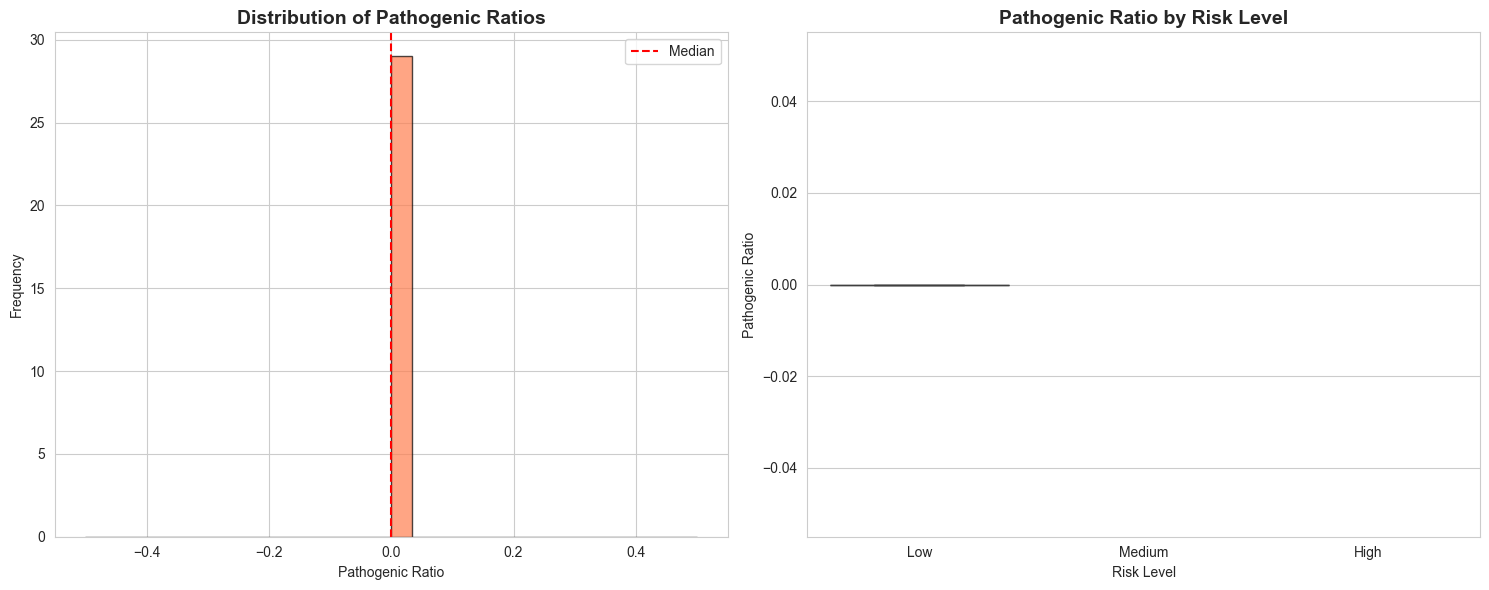


Pathogenic Ratio Statistics:
  Mean: 0.0000
  Median: 0.0000
  Std Dev: 0.0000
  Min: 0.0000
  Max: 0.0000


In [11]:
# Distribution Analysis - Pathogenic Ratio

print("\n" + "="*40)
print("DISTRIBUTION ANALYSIS - PATHOGENIC RATIO")
print("="*40)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram
axes[0].hist(df_clean['pathogenic_ratio'], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[0].set_title('Distribution of Pathogenic Ratios', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Pathogenic Ratio')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df_clean['pathogenic_ratio'].median(), color='red', 
               linestyle='--', label='Median')
axes[0].legend()

# Box plot by risk level
risk_order = ['Low', 'Medium', 'High']
df_clean['risk_level'] = pd.Categorical(df_clean['risk_level'], 
                                         categories=risk_order, 
                                         ordered=True)
sns.boxplot(data=df_clean, x='risk_level', y='pathogenic_ratio', ax=axes[1])
axes[1].set_title('Pathogenic Ratio by Risk Level', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Risk Level')
axes[1].set_ylabel('Pathogenic Ratio')

plt.tight_layout()
plt.savefig(VIZ_DIR / 'pathogenic_ratio_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPathogenic Ratio Statistics:")
print(f"  Mean: {df_clean['pathogenic_ratio'].mean():.4f}")
print(f"  Median: {df_clean['pathogenic_ratio'].median():.4f}")
print(f"  Std Dev: {df_clean['pathogenic_ratio'].std():.4f}")
print(f"  Min: {df_clean['pathogenic_ratio'].min():.4f}")
print(f"  Max: {df_clean['pathogenic_ratio'].max():.4f}")


HYPOTHESIS TEST 1: ANOVA
Do different chromosomes have significantly different mutation counts?

ANOVA Results:
  F-statistic: 0.5701
  P-value: 0.8304
  Alpha level: 0.05
  Chromosomes tested: 13

Conclusion: FAIL TO REJECT null hypothesis
  No significant difference in mutation counts across chromosomes
  Note: Small sample size may limit statistical power


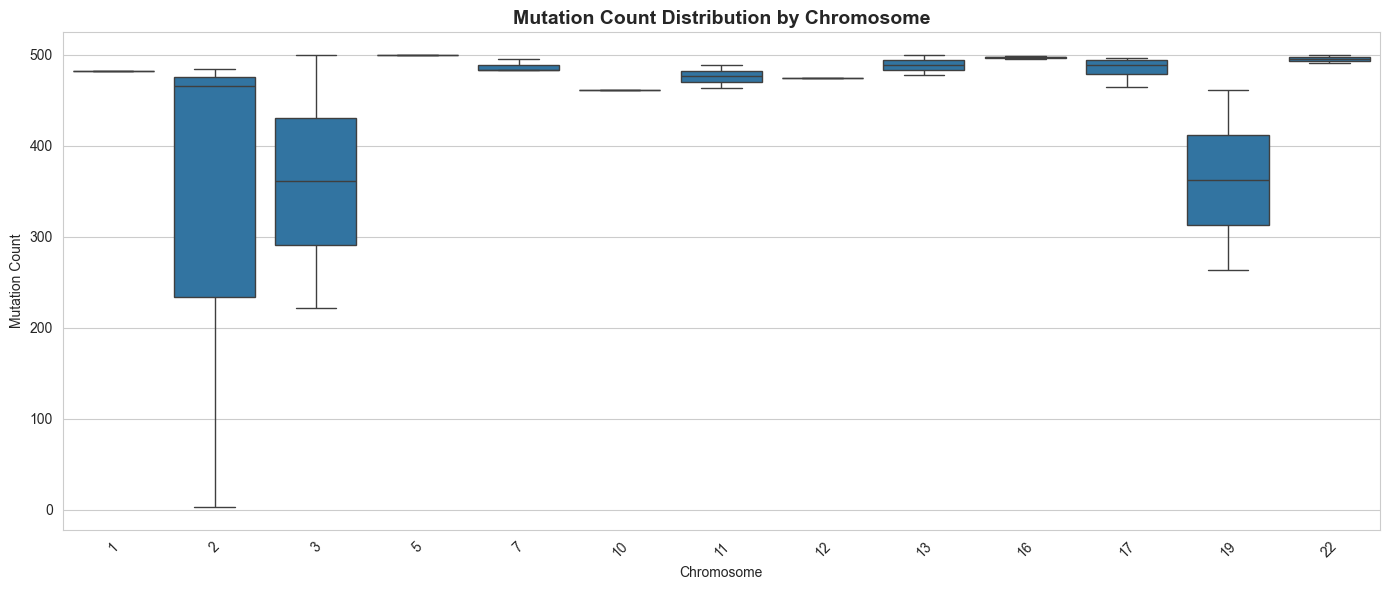

In [12]:
# Hypothesis Test 1 - ANOVA (Chromosomes vs Mutation Counts)

print("\n" + "="*40)
print("HYPOTHESIS TEST 1: ANOVA")
print("Do different chromosomes have significantly different mutation counts?")
print("="*40)

# Prepare data by chromosome (only numeric chromosomes for comparison)
numeric_chroms = [str(i) for i in range(1, 23)]
df_numeric_chroms = df_clean[df_clean['chromosome'].isin(numeric_chroms)].copy()

chromosome_groups = []
for chrom in sorted(df_numeric_chroms['chromosome'].unique()):
    group_data = df_numeric_chroms[df_numeric_chroms['chromosome'] == chrom]['mutation_count'].values
    if len(group_data) > 0:
        chromosome_groups.append(group_data)

# Perform ANOVA
if len(chromosome_groups) > 1:
    f_statistic, p_value = stats.f_oneway(*chromosome_groups)
    
    print(f"\nANOVA Results:")
    print(f"  F-statistic: {f_statistic:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Alpha level: 0.05")
    print(f"  Chromosomes tested: {len(chromosome_groups)}")
    
    if p_value < 0.05:
        print(f"\nConclusion: REJECT null hypothesis")
        print(f"  Chromosomes have significantly different mutation counts (p < 0.05)")
    else:
        print(f"\nConclusion: FAIL TO REJECT null hypothesis")
        print(f"  No significant difference in mutation counts across chromosomes")
        print(f"  Note: Small sample size may limit statistical power")
else:
    print("Not enough chromosome groups for ANOVA")

# Visualization (only numeric chromosomes, sorted)
plt.figure(figsize=(14, 6))
chrom_order = sorted([c for c in df_numeric_chroms['chromosome'].unique()], key=lambda x: int(x))
sns.boxplot(data=df_numeric_chroms, x='chromosome', y='mutation_count', order=chrom_order)
plt.title('Mutation Count Distribution by Chromosome', fontsize=14, fontweight='bold')
plt.xlabel('Chromosome')
plt.ylabel('Mutation Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(VIZ_DIR / 'chromosome_mutation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


HYPOTHESIS TEST 2: CHI-SQUARE TEST
Is there an association between chromosome and risk level?

Contingency Table:
risk_level  Low
chromosome     
1             1
10            1
11            2
12            1
13            2
16            2
17            4
19            2
2             3
22            2
3             2
5             1
7             3

Chi-Square Test Results:
  Chi-square statistic: 0.0000
  P-value: 1.0000
  Degrees of freedom: 0
  Alpha level: 0.05

Conclusion: FAIL TO REJECT null hypothesis
  No significant association between chromosome and risk level


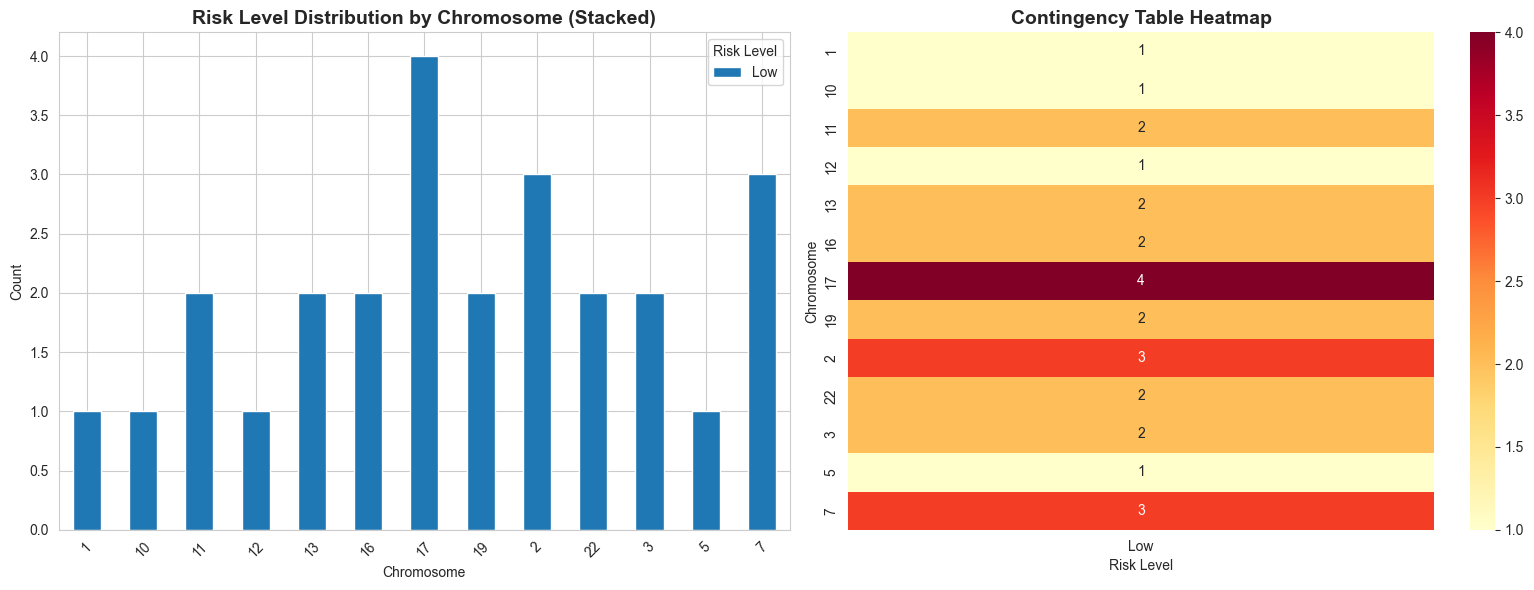

In [13]:
# Hypothesis Test 2 - Chi-Square (Risk Level vs Chromosome)

print("\n" + "="*40)
print("HYPOTHESIS TEST 2: CHI-SQUARE TEST")
print("Is there an association between chromosome and risk level?")
print("="*40)

# Use only numeric chromosomes for cleaner analysis
contingency_table = pd.crosstab(df_numeric_chroms['chromosome'], df_numeric_chroms['risk_level'])
print("\nContingency Table:")
print(contingency_table)

# Only perform test if we have enough data
if contingency_table.size > 0 and contingency_table.min().min() >= 1:
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f"\nChi-Square Test Results:")
    print(f"  Chi-square statistic: {chi2:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Degrees of freedom: {dof}")
    print(f"  Alpha level: 0.05")
    
    if p_value < 0.05:
        print(f"\nConclusion: REJECT null hypothesis")
        print(f"  There IS a significant association between chromosome and risk level")
    else:
        print(f"\nConclusion: FAIL TO REJECT null hypothesis")
        print(f"  No significant association between chromosome and risk level")
else:
    print("\nInsufficient data for Chi-Square test")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

contingency_table.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Risk Level Distribution by Chromosome (Stacked)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Chromosome')
axes[0].set_ylabel('Count')
axes[0].legend(title='Risk Level')
axes[0].tick_params(axis='x', rotation=45)

sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1])
axes[1].set_title('Contingency Table Heatmap', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Risk Level')
axes[1].set_ylabel('Chromosome')

plt.tight_layout()
plt.savefig(VIZ_DIR / 'risk_chromosome_association.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Hypothesis Test 3 - T-Test (High vs Low Risk)

print("\n" + "="*40)
print("HYPOTHESIS TEST 3: INDEPENDENT T-TEST")
print("Do High-risk genes have significantly more mutations than Low-risk genes?")
print("="*40)

high_risk = df_clean[df_clean['risk_level'] == 'High']['mutation_count']
low_risk = df_clean[df_clean['risk_level'] == 'Low']['mutation_count']

print(f"High-risk genes: n={len(high_risk)}, mean={high_risk.mean():.2f}")
print(f"Low-risk genes: n={len(low_risk)}, mean={low_risk.mean():.2f}")

if len(high_risk) > 0 and len(low_risk) > 0:
    t_statistic, p_value = stats.ttest_ind(high_risk, low_risk)
    
    print(f"\nT-Test Results:")
    print(f"  T-statistic: {t_statistic:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Alpha level: 0.05")
    
    if p_value < 0.05:
        print(f"\nConclusion: REJECT null hypothesis")
        print(f"  High-risk genes have significantly different mutation counts than Low-risk genes")
    else:
        print(f"\nConclusion: FAIL TO REJECT null hypothesis")
        print(f"  No significant difference in mutation counts")
    
    # Visualization
    plt.figure(figsize=(10, 6))
    data_to_plot = [high_risk, low_risk]
    plt.boxplot(data_to_plot, labels=['High Risk', 'Low Risk'], patch_artist=True)
    plt.title('Mutation Count: High Risk vs Low Risk Genes', fontsize=14, fontweight='bold')
    plt.ylabel('Mutation Count')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(VIZ_DIR / 'high_vs_low_risk_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("\nInsufficient data for T-test (need both High and Low risk genes)")


HYPOTHESIS TEST 3: INDEPENDENT T-TEST
Do High-risk genes have significantly more mutations than Low-risk genes?
High-risk genes: n=0, mean=nan
Low-risk genes: n=29, mean=451.38

Insufficient data for T-test (need both High and Low risk genes)



CORRELATION ANALYSIS

Correlation Matrix:
                  mutation_count  pathogenic_count  total_pathogenic  \
mutation_count               1.0               NaN               NaN   
pathogenic_count             NaN               NaN               NaN   
total_pathogenic             NaN               NaN               NaN   
pathogenic_ratio             NaN               NaN               NaN   
disease_count                NaN               NaN               NaN   
risk_score                   1.0               NaN               NaN   

                  pathogenic_ratio  disease_count  risk_score  
mutation_count                 NaN            NaN         1.0  
pathogenic_count               NaN            NaN         NaN  
total_pathogenic               NaN            NaN         NaN  
pathogenic_ratio               NaN            NaN         NaN  
disease_count                  NaN            NaN         NaN  
risk_score                     NaN            NaN         1.0  


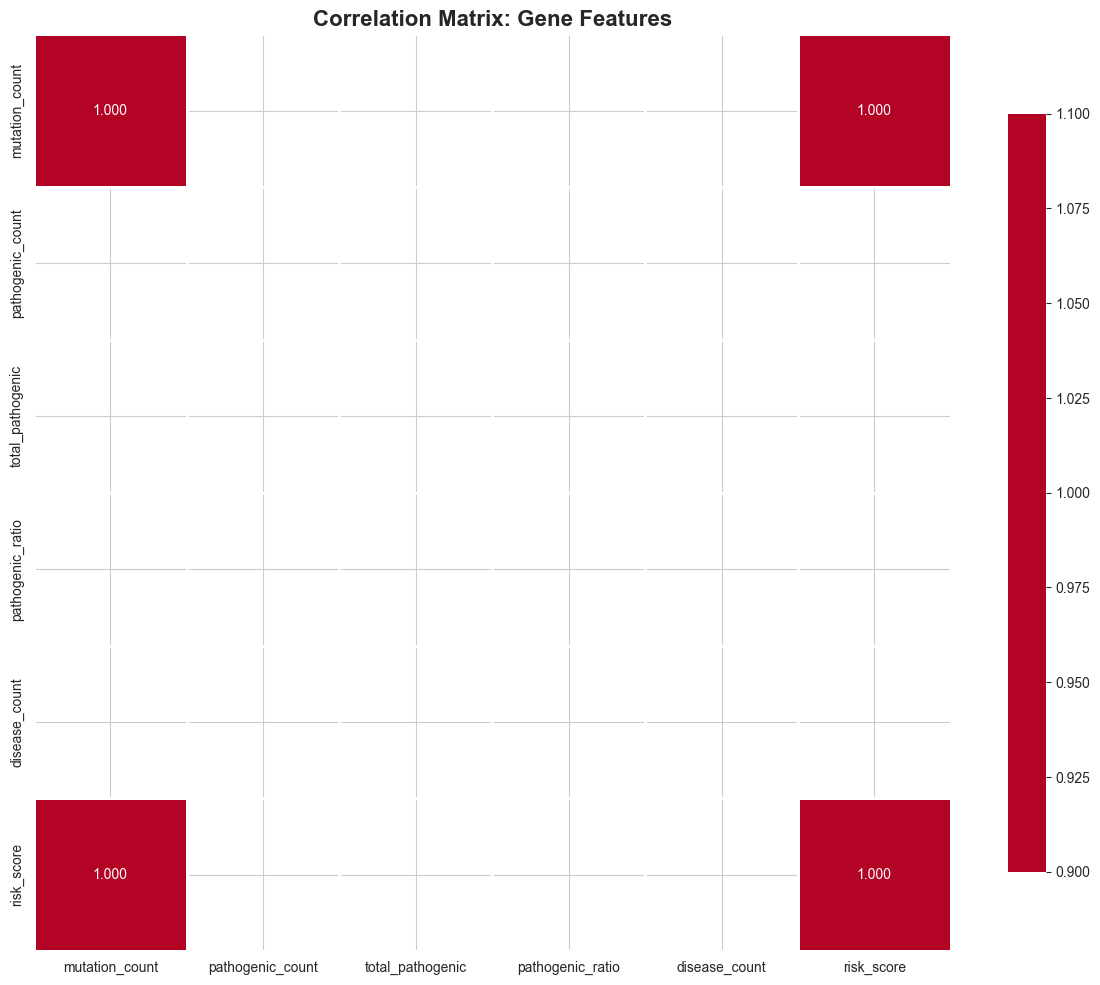


Strong Correlations (|r| > 0.7):
  mutation_count <-> risk_score: 1.000


In [15]:
# Correlation Analysis

print("\n" + "="*40)
print("CORRELATION ANALYSIS")
print("="*40)

# Select numeric columns that exist
numeric_cols = ['mutation_count', 'pathogenic_count', 'total_pathogenic', 
                'pathogenic_ratio', 'disease_count', 'risk_score']
available_cols = [col for col in numeric_cols if col in df_clean.columns]
correlation_data = df_clean[available_cols].dropna()

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

# Visualization
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Gene Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Find strong correlations
print("\nStrong Correlations (|r| > 0.7):")
found_strong = False
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            print(f"  {correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")
            found_strong = True
if not found_strong:
    print("  No correlations found with |r| > 0.7")


DISEASE ASSOCIATION ANALYSIS

Top 10 Diseases by Gene Count:
disease
Lynch Syndrome                       3
Breast Cancer                        2
Breast and Ovarian Cancer            2
HTT associated disorder              1
Hemophilia B                         1
Hereditary Diffuse Gastric Cancer    1
KCNK12 associated disorder           1
KLLN associated disorder             1
KRAS associated disorder             1
LOC106099062 associated disorder     1
dtype: int64


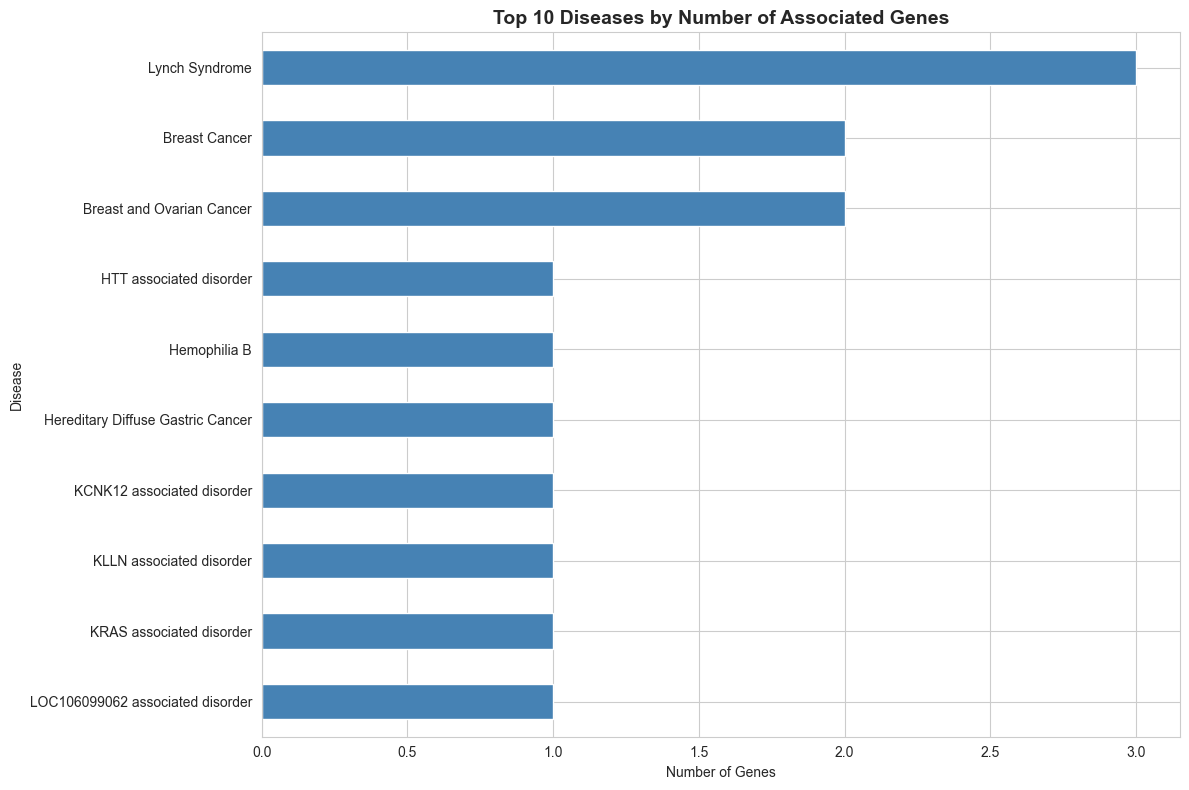


Association Strength Distribution:
association_strength
Weak    62
Name: count, dtype: int64


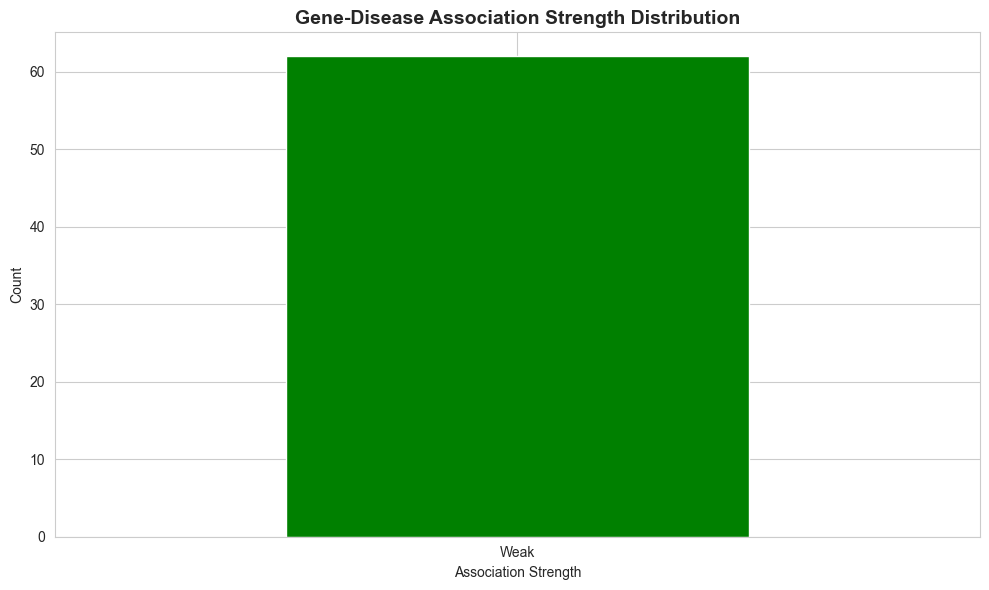

In [16]:
# Disease Association Analysis

print("\n" + "="*40)
print("DISEASE ASSOCIATION ANALYSIS")
print("="*40)

# Top diseases by gene count
top_diseases = df_gene_disease.groupby('disease').size().sort_values(ascending=False).head(10)
print("\nTop 10 Diseases by Gene Count:")
print(top_diseases)

# Visualization
plt.figure(figsize=(12, 8))
top_diseases.plot(kind='barh', color='steelblue')
plt.title('Top 10 Diseases by Number of Associated Genes', fontsize=14, fontweight='bold')
plt.xlabel('Number of Genes')
plt.ylabel('Disease')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(VIZ_DIR / 'top_diseases.png', dpi=300, bbox_inches='tight')
plt.show()

# Association strength distribution
print("\nAssociation Strength Distribution:")
print(df_gene_disease['association_strength'].value_counts())

plt.figure(figsize=(10, 6))
df_gene_disease['association_strength'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Gene-Disease Association Strength Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Association Strength')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(VIZ_DIR / 'association_strength.png', dpi=300, bbox_inches='tight')
plt.show()
    

In [17]:
# Summary Statistics Report

print("\n" + "="*40)
print("STATISTICAL ANALYSIS SUMMARY REPORT")
print("="*40)

summary_report = {
    'Total Genes Analyzed': len(df_clean),
    'Total Chromosomes': df_clean['chromosome'].nunique(),
    'Total Diseases': len(df_gene_disease['disease'].unique()),
    'Mean Mutations per Gene': df_clean['mutation_count'].mean(),
    'Median Mutations per Gene': df_clean['mutation_count'].median(),
    'Mean Pathogenic Ratio': df_clean['pathogenic_ratio'].mean(),
    'High Risk Genes': len(df_clean[df_clean['risk_level'] == 'High']),
    'Medium Risk Genes': len(df_clean[df_clean['risk_level'] == 'Medium']),
    'Low Risk Genes': len(df_clean[df_clean['risk_level'] == 'Low'])
}

for key, value in summary_report.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")


STATISTICAL ANALYSIS SUMMARY REPORT
Total Genes Analyzed: 29
Total Chromosomes: 14
Total Diseases: 58
Mean Mutations per Gene: 451.38
Median Mutations per Gene: 484.00
Mean Pathogenic Ratio: 0.00
High Risk Genes: 0
Medium Risk Genes: 0
Low Risk Genes: 29


In [18]:
# Save Analysis Results

print("\n" + "="*40)
print("SAVING ANALYSIS RESULTS")
print("="*40)

# Save summary statistics
summary_df = pd.DataFrame([summary_report]).T
summary_df.columns = ['Value']
summary_df.to_csv(ANALYTICAL_DIR / 'summary_statistics.csv')
print(f"Saved: {ANALYTICAL_DIR / 'summary_statistics.csv'}")

# Save correlation matrix
correlation_matrix.to_csv(ANALYTICAL_DIR / 'correlation_matrix.csv')
print(f"Saved: {ANALYTICAL_DIR / 'correlation_matrix.csv'}")

print("\nStatistical Analysis Complete!")
print(f"Visualizations saved in: {VIZ_DIR}")

# Close database connection
conn.close()
print("\nDatabase connection closed")


SAVING ANALYSIS RESULTS
Saved: C:\Users\Sharique\Desktop\Self_Project\GitHub_Project\genomic-variant-data-science-pipeline\data\analytical\summary_statistics.csv
Saved: C:\Users\Sharique\Desktop\Self_Project\GitHub_Project\genomic-variant-data-science-pipeline\data\analytical\correlation_matrix.csv

Statistical Analysis Complete!
Visualizations saved in: C:\Users\Sharique\Desktop\Self_Project\GitHub_Project\genomic-variant-data-science-pipeline\data\analytical\visualizations

Database connection closed
